## 1. Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score
)
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## 2. Cargar Datos

In [4]:
df = pd.read_csv('/.../student_entry_performance_modified.csv')

In [5]:
print(f"📊 Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")
df.head()

📊 Dataset cargado: 679 filas, 13 columnas


,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_ X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation,mixed_type_col
0,Excellent,male,General,NO,one,SEBA,AHSEC,ENGLISH,Excellent,Excellent,DOCTOR,OTHERS,unknown
1,Excellent,MALE,OBC,WA,TWO,SEBA,AHSEC,OTHERS,Excellent,Excellent,SCHOOL_TEACHER,HOUSE_WIFE,666
2,Excellent,male,OBC,OA,TWO,others,CBSE,ENGLISH,Excellent,Excellent,BUSINESS,HOUSE_WIFE,unknown
3,Excellent,male,General,WA,one,SEBA,AHSEC,OTHERS,Excellent,eXCELLENT,SCHOOL_TEACHER,school_teacher,275
4,Excellent,male,General,OA,two,NaN,CBSE,ENGLISH,Excellent,Excellent,COLLEGE_TEACHER,HOUSE_WIFE,6


## 3. Análisis Exploratorio de Datos (EDA)

In [6]:
# Información general
print("=== INFORMACIÓN GENERAL ===")
print(df.info())
print("\n=== VALORES NULOS ===")
print(df.isnull().sum())
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())

=== INFORMACIÓN GENERAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Performance           673 non-null    object
 1   Gender                673 non-null    object
 2   Caste                 675 non-null    object
 3   coaching              673 non-null    object
 4   time                  674 non-null    object
 5   Class_ten_education   668 non-null    object
 6   twelve_education      670 non-null    object
 7   medium                673 non-null    object
 8   Class_ X_Percentage   675 non-null    object
 9   Class_XII_Percentage  672 non-null    object
 10  Father_occupation     676 non-null    object
 11  Mother_occupation     674 non-null    object
 12  mixed_type_col        611 non-null    object
dtypes: object(13)
memory usage: 69.1+ KB
None

=== VALORES NULOS ===
Performance              6
Gender              

In [7]:
# Análisis de la variable objetivo
print("=== DISTRIBUCIÓN DE PERFORMANCE (antes de limpiar) ===")
print(df['Performance'].value_counts())

=== DISTRIBUCIÓN DE PERFORMANCE (antes de limpiar) ===
Performance
Good           199
Vg             194
Average        146
Excellent       96
 gOOD           14
 aVERAGE        12
 vG              6
 eXCELLENT       6
Name: count, dtype: int64


## 4. Limpieza de Datos

In [8]:
# Función para limpiar texto
def clean_text(text):
    if pd.isna(text):
        return text
    return str(text).strip().upper()

In [9]:
# Limpiar todas las columnas de texto
text_columns = df.select_dtypes(include=['object']).columns

In [10]:
for col in text_columns:
    df[col] = df[col].apply(clean_text)

In [11]:
print("✅ Texto limpiado y estandarizado")

✅ Texto limpiado y estandarizado


In [12]:
# Estandarizar categorías de Performance
performance_mapping = {
    'EXCELLENT': 'Excellent',
    'VG': 'Very Good',
    'GOOD': 'Good',
    'AVERAGE': 'Average'
}

In [13]:
df['Performance'] = df['Performance'].map(performance_mapping)

In [14]:
print("=== DISTRIBUCIÓN DE PERFORMANCE (después de limpiar) ===")
print(df['Performance'].value_counts())
print(f"\n✅ Categorías estandarizadas: {df['Performance'].unique()}")

=== DISTRIBUCIÓN DE PERFORMANCE (después de limpiar) ===
Performance
Good         213
Very Good    200
Average      158
Excellent    102
Name: count, dtype: int64

✅ Categorías estandarizadas: ['Excellent' nan 'Very Good' 'Good' 'Average']


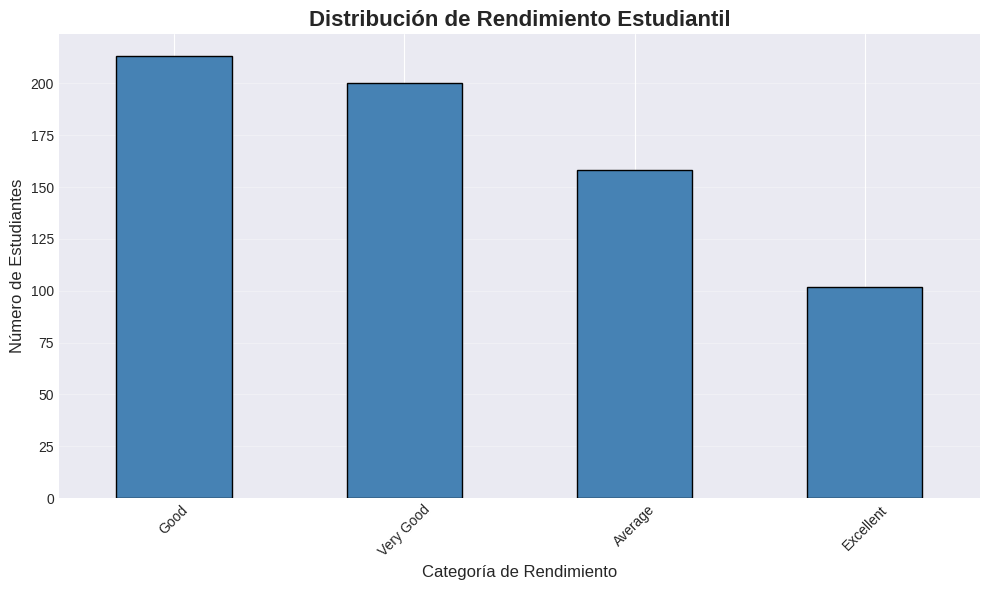

In [15]:
# Visualizar distribución de la variable objetivo
plt.figure(figsize=(10, 6))
df['Performance'].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribución de Rendimiento Estudiantil', fontsize=16, fontweight='bold')
plt.xlabel('Categoría de Rendimiento', fontsize=12)
plt.ylabel('Número de Estudiantes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Analizar variables categóricas importantes
categorical_features = ['Gender', 'Caste', 'coaching', 'medium',
                        'Father_occupation', 'Mother_occupation']

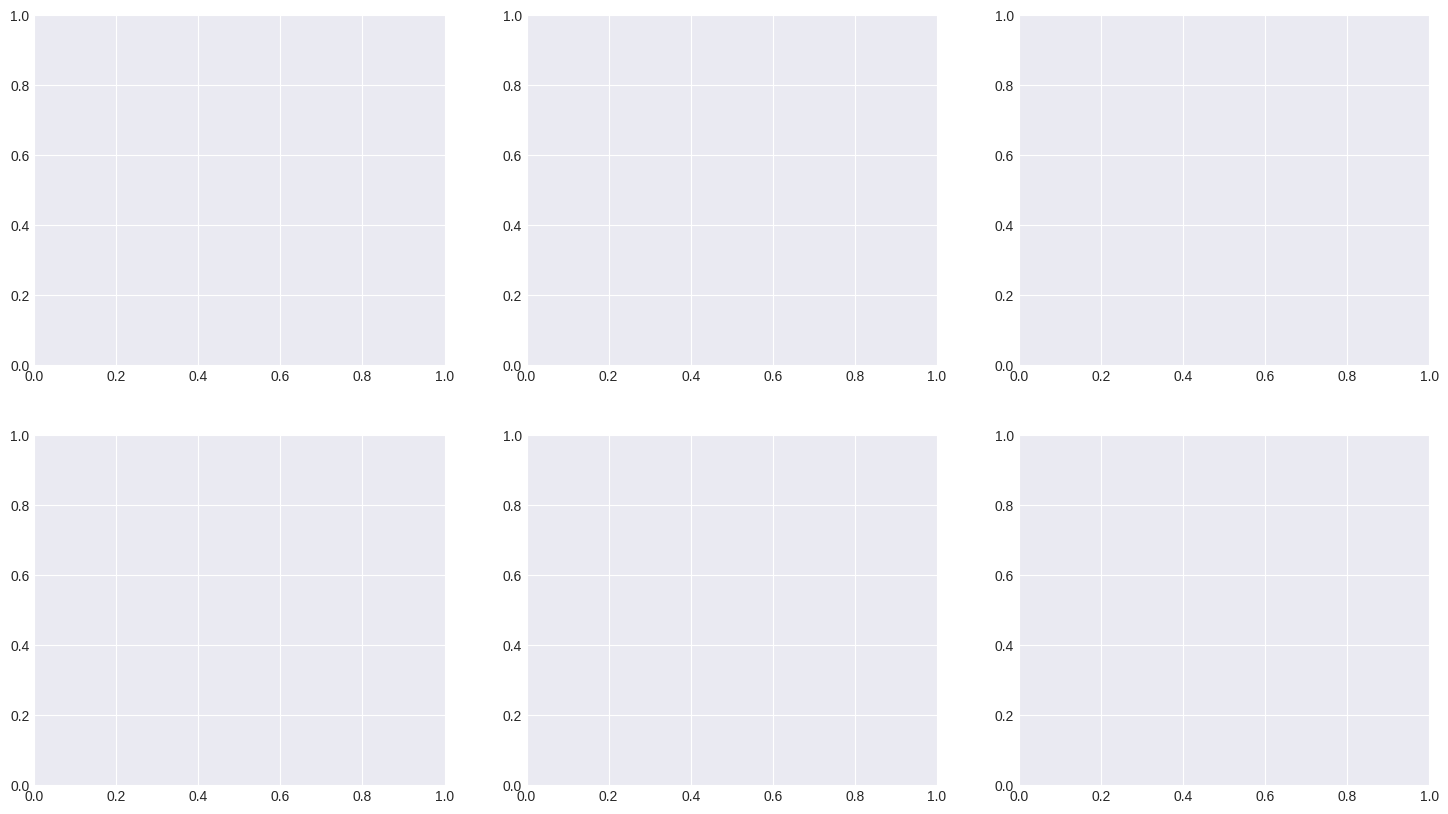

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

In [18]:
for idx, col in enumerate(categorical_features):
    top_categories = df[col].value_counts().head(10)
    top_categories.plot(kind='bar', ax=axes[idx], color='coral', edgecolor='black')
    axes[idx].set_title(f'Distribución de {col}', fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)

In [20]:
plt.show()

## 5. Preparación de Datos para Modelado

In [21]:
# Crear copia para modelado
df_model = df.copy()

In [22]:
# Eliminar columna mixed_type_col (parece ser ruido)
if 'mixed_type_col' in df_model.columns:
    df_model = df_model.drop('mixed_type_col', axis=1)

In [23]:
# Manejar valores faltantes
print(f"Valores nulos antes: {df_model.isnull().sum().sum()}")
df_model = df_model.dropna()
print(f"Valores nulos después: {df_model.isnull().sum().sum()}")
print(f"Filas restantes: {len(df_model)}")

Valores nulos antes: 72
Valores nulos después: 0
Filas restantes: 610


In [24]:
# Separar features y target
X = df_model.drop('Performance', axis=1)
y = df_model['Performance']

In [25]:
print(f"✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")

✅ Features (X): (610, 11)
✅ Target (y): (610,)


In [26]:
# Codificar variables categóricas
label_encoders = {}

In [27]:
for column in X.columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column].astype(str))
    label_encoders[column] = le

In [28]:
# Codificar variable objetivo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [29]:
print("✅ Variables codificadas")
print(f"\nClases objetivo: {le_target.classes_}")
print(f"Encodings: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

✅ Variables codificadas

Clases objetivo: ['Average' 'Excellent' 'Good' 'Very Good']
Encodings: {'Average': np.int64(0), 'Excellent': np.int64(1), 'Good': np.int64(2), 'Very Good': np.int64(3)}


In [30]:
# Guardar datos procesados
processed_data = df_model.copy()
processed_data.to_csv('/.../student_performance_clean.csv', index=False)
print("✅ Datos procesados guardados en: data/processed/student_performance_clean.csv")

✅ Datos procesados guardados en: data/processed/student_performance_clean.csv


## 6. División Train-Test

In [31]:
# Split de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [32]:
print(f"📊 Conjunto de Entrenamiento: {X_train.shape}")
print(f"📊 Conjunto de Prueba: {X_test.shape}")
print(f"\n✅ Distribución balanceada (stratify)")

📊 Conjunto de Entrenamiento: (488, 11)
📊 Conjunto de Prueba: (122, 11)

✅ Distribución balanceada (stratify)


7. Entrenamiento del Modelo - Árbol de Decisión

In [33]:
# Modelo base
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced'
)

In [34]:
# Entrenar modelo
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10, min_samples_split=20,
                       random_state=42)

In [35]:
# Predicciones
y_pred_train = dt_model.predict(X_train)
y_pred_test = dt_model.predict(X_test)

In [36]:
# Métricas
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

## 8. Optimización de Hiperparámetros

In [37]:
# Grid Search para encontrar mejores hiperparámetros
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'criterion': ['gini', 'entropy']
}

In [38]:
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [39]:
print("🔍 Buscando mejores hiperparámetros...")
grid_search.fit(X_train, y_train)

🔍 Buscando mejores hiperparámetros...
Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 20, 30]},
             scoring='accuracy', verbose=1)

In [40]:
print(f"\n✅ Mejor Score (CV): {grid_search.best_score_:.4f}")
print(f"✅ Mejores Parámetros: {grid_search.best_params_}")


✅ Mejor Score (CV): 0.4837
✅ Mejores Parámetros: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}


In [41]:
# Modelo optimizado
best_dt_model = grid_search.best_estimator_

In [42]:
# Predicciones con modelo optimizado
y_pred_train_opt = best_dt_model.predict(X_train)
y_pred_test_opt = best_dt_model.predict(X_test)

In [43]:
# Métricas modelo optimizado
train_accuracy_opt = accuracy_score(y_train, y_pred_train_opt)
test_accuracy_opt = accuracy_score(y_test, y_pred_test_opt)

In [44]:
print("\n=== RESULTADOS MODELO OPTIMIZADO ===")
print(f"Accuracy (Train): {train_accuracy_opt:.4f}")
print(f"Accuracy (Test): {test_accuracy_opt:.4f}")
print(f"\n📈 Mejora en Test: {(test_accuracy_opt - test_accuracy):.4f}")


=== RESULTADOS MODELO OPTIMIZADO ===
Accuracy (Train): 0.5451
Accuracy (Test): 0.4098

📈 Mejora en Test: -0.0082


## 9. Evaluación del Modelo

In [45]:
# Reporte de clasificación
print("=== CLASSIFICATION REPORT ===")
print(classification_report(
    y_test,
    y_pred_test_opt,
    target_names=le_target.classes_
))

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     Average       0.66      0.82      0.73        28
   Excellent       0.26      0.47      0.34        19
        Good       0.34      0.33      0.34        39
   Very Good       0.33      0.14      0.20        36

    accuracy                           0.41       122
   macro avg       0.40      0.44      0.40       122
weighted avg       0.40      0.41      0.39       122



In [46]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test_opt)

<Axes: >

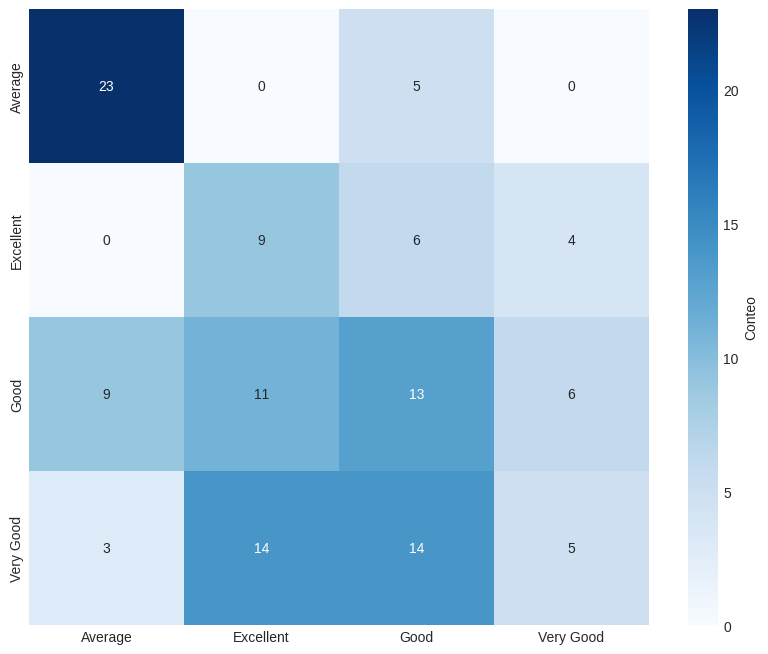

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_,
    cbar_kws={'label': 'Conteo'}
)

In [48]:
# Importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES ===")
print(feature_importance.head(10))

=== TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES ===
                 feature  importance
1                  Caste    0.739570
7    Class_ X_Percentage    0.047372
9      Father_occupation    0.046661
3                   time    0.033416
6                 medium    0.033316
8   Class_XII_Percentage    0.031762
2               coaching    0.024707
0                 Gender    0.016603
5       twelve_education    0.013674
10     Mother_occupation    0.012919


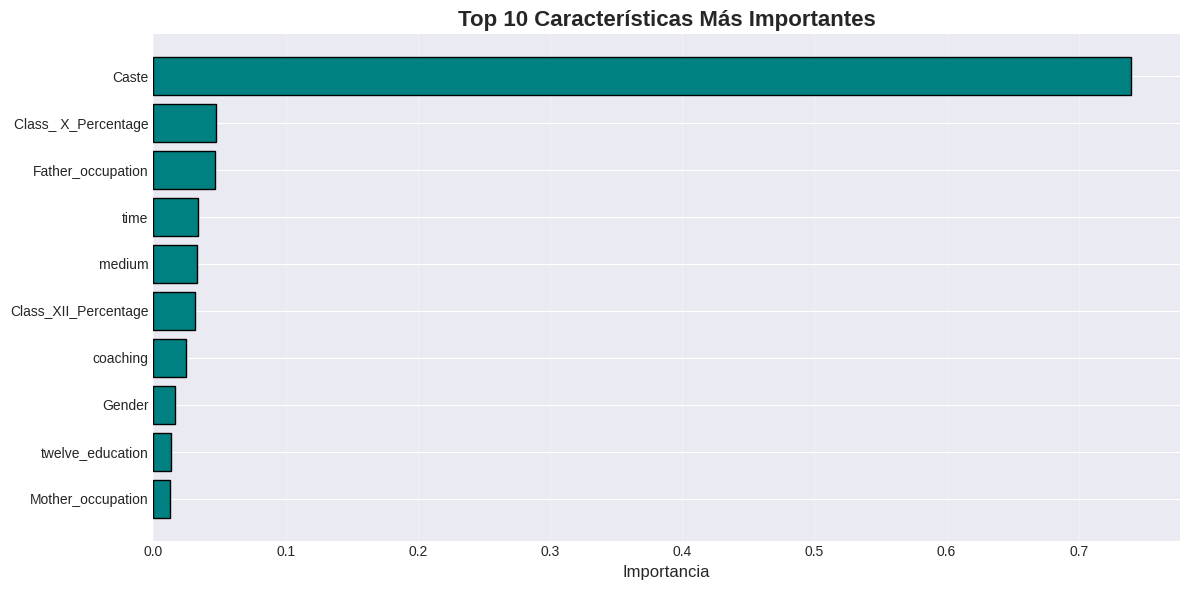

In [49]:
# Visualizar
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'], color='teal', edgecolor='black')
plt.xlabel('Importancia', fontsize=12)
plt.title('Top 10 Características Más Importantes', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

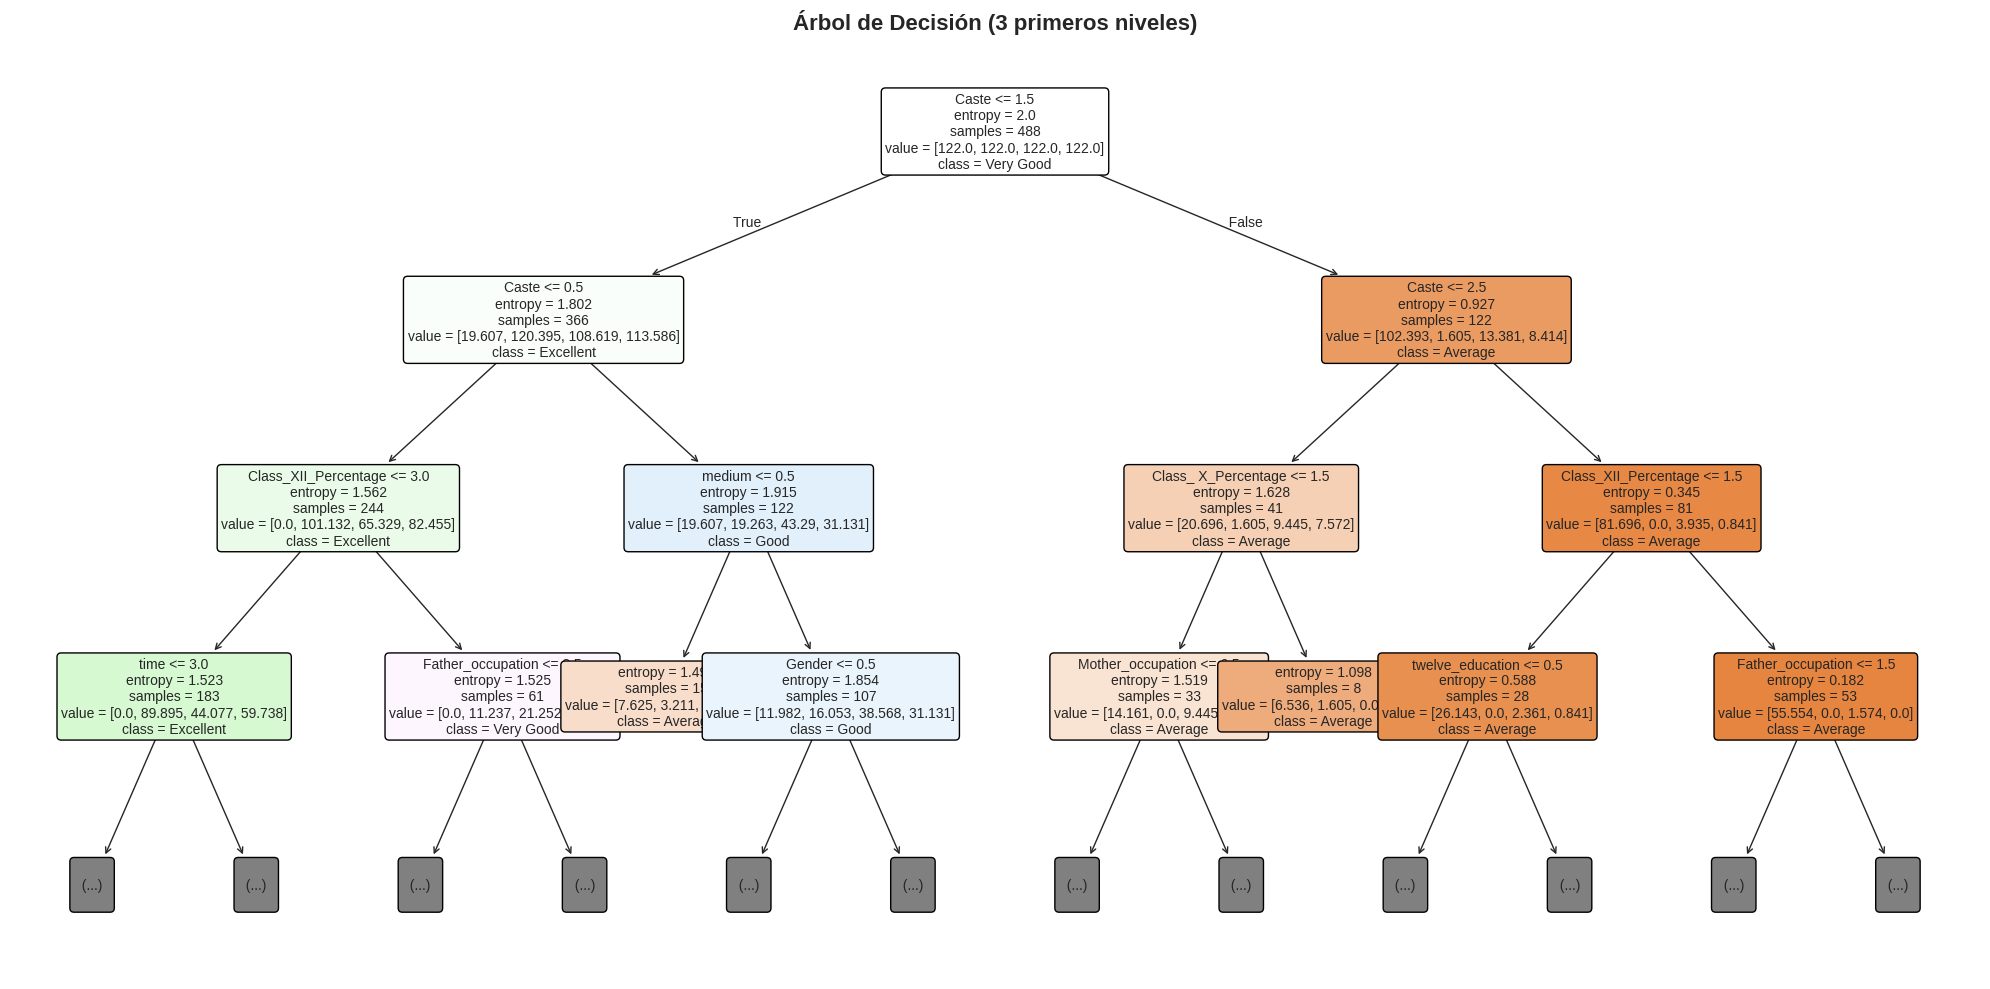

In [52]:
# Visualizar el árbol de decisión (primeros niveles)
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model,
    max_depth=3,  # Solo mostrar 3 niveles para visualización
    feature_names=X.columns,
    class_names=le_target.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)

plt.title('Árbol de Decisión (3 primeros niveles)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [53]:
metrics = {
    'train_accuracy': train_accuracy_opt,
    'test_accuracy': test_accuracy_opt,
    'best_params': grid_search.best_params_,
    'cv_score': grid_search.best_score_,
    'feature_importance': feature_importance.to_dict('records')
}

In [54]:
print("=== Métricas ===")
print(metrics)

=== Métricas ===
{'train_accuracy': 0.5450819672131147, 'test_accuracy': 0.4098360655737705, 'best_params': {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 20}, 'cv_score': np.float64(0.4836945087313276), 'feature_importance': [{'feature': 'Caste', 'importance': 0.7395702903160998}, {'feature': 'Class_ X_Percentage', 'importance': 0.04737173705018918}, {'feature': 'Father_occupation', 'importance': 0.04666070038379125}, {'feature': 'time', 'importance': 0.03341630979728097}, {'feature': 'medium', 'importance': 0.033315758810368204}, {'feature': 'Class_XII_Percentage', 'importance': 0.03176200255538729}, {'feature': 'coaching', 'importance': 0.024707376904303326}, {'feature': 'Gender', 'importance': 0.016602874194639614}, {'feature': 'twelve_education', 'importance': 0.013674026054769346}, {'feature': 'Mother_occupation', 'importance': 0.012918923933170805}, {'feature': 'Class_ten_education', 'importance': 0.0}]}


## 11. Resumen Final


In [55]:
print("=" * 60)
print("🎯 RESUMEN DEL MODELO DE ÁRBOL DE DECISIÓN")
print("=" * 60)
print(f"\n📊 Dataset Original: {df.shape[0]} estudiantes")
print(f"📊 Dataset Limpio: {len(df_model)} estudiantes")
print(f"📊 Features: {X.shape[1]}")
print(f"📊 Clases objetivo: {len(le_target.classes_)}")
print(f"\n🎯 Accuracy en Entrenamiento: {train_accuracy_opt:.4f}")
print(f"🎯 Accuracy en Test: {test_accuracy_opt:.4f}")
print("\n" + "=" * 60)
print("🚀 Modelo listo para producción!")
print("=" * 60)

🎯 RESUMEN DEL MODELO DE ÁRBOL DE DECISIÓN

📊 Dataset Original: 679 estudiantes
📊 Dataset Limpio: 610 estudiantes
📊 Features: 11
📊 Clases objetivo: 4

🎯 Accuracy en Entrenamiento: 0.5451
🎯 Accuracy en Test: 0.4098

✅ Modelo guardado exitosamente
✅ Encoders guardados exitosamente
✅ Métricas guardadas exitosamente

🚀 Modelo listo para producción!
